# Examle 06: PyTorch Image-generation by RNN

## 事前準備

In [1]:
import torch

# GPUが使えるか確認してデバイスを設定
# NOTE: `x = x.to(device) ` とすることで対象のデバイスに切り替え可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## RNNによる画像生成

画像の上半分から画像の下半分を生成する。

In [2]:
import torch
import torchinfo
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

### データ用意(Fashion MNIST)

In [3]:
fmnist_data = FashionMNIST(root="../cache/data",
                           train=True,
                           download=True,
                           transform=transforms.ToTensor())

fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
len(fmnist_data)

60000

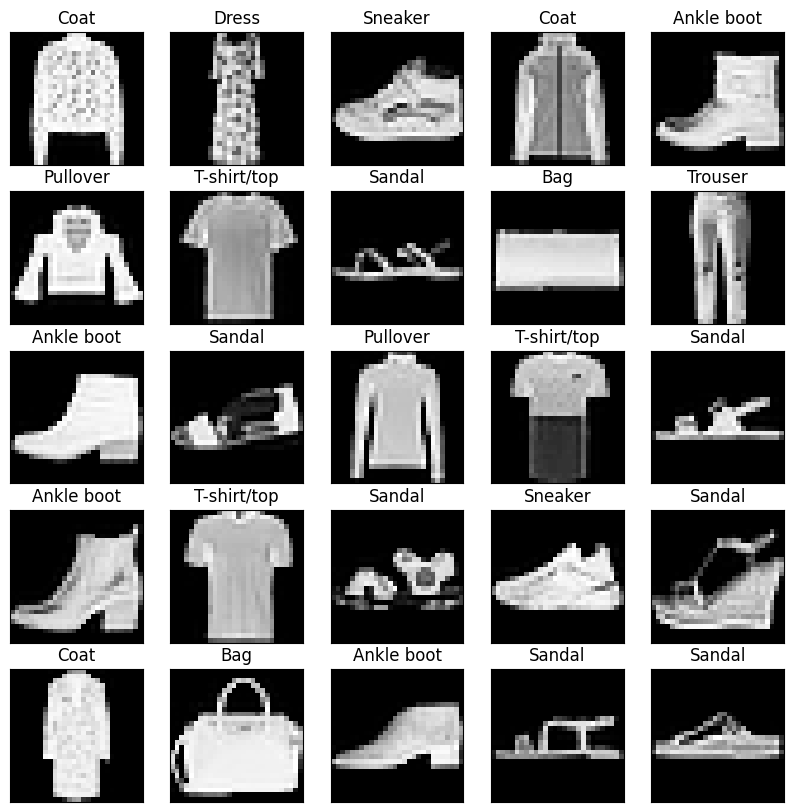

In [5]:
n_image = 25
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image, shuffle=True)
data_iter = iter(fmnist_loader)
images, labels = next(data_iter)

img_size = 28
plt.figure(figsize=(10, 10))
for i in range(n_image):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(images[i].reshape(img_size, img_size), cmap="Greys_r")
    ax.set_title(fmnist_classes[labels[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### データ前処理

In [6]:
n_time = 14                             # 時系列データ幅
n_in = img_size                         # 入力層ニューロン数
n_mid = 256                             # 中間層ニューロン数
n_out = img_size                        # 出力層ニューロン数
n_sample_in_img = img_size - n_time     # 1枚の画像中のサンプル数

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
data_iter = iter(dataloader)
train_imgs, train_labels = next(data_iter)
train_imgs = train_imgs.view(-1, img_size, img_size)

n_sample = len(train_imgs) * n_sample_in_img

input_data = torch.zeros((n_sample, n_time, n_in))
correct_data = torch.zeros((n_sample, n_out))

for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i * n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j + n_time]
        correct_data[sample_id] = train_imgs[i, j + n_time]

In [7]:
input_data.shape, correct_data.shape

(torch.Size([840000, 14, 28]), torch.Size([840000, 28]))

### DataLoader作成

In [8]:
n_batch = 128

dataset = TensorDataset(input_data, correct_data)
train_loader = DataLoader(dataset, batch_size=n_batch, shuffle=True)

### テスト用データ

In [9]:
n_disp = 10

disp_data = FashionMNIST(root="../cache/data",
                         train=False,
                         download=True,
                         transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
data_iter = iter(disp_loader)
disp_imgs, disp_labels = next(data_iter)
disp_imgs = disp_imgs.view(-1, img_size, img_size)

### モデル構築

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(input_size=n_in, hidden_size=n_mid, batch_first=True)
        self.fc = nn.Linear(n_mid, n_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_rnn, (h, c) = self.rnn(x, None)
        y = self.fc(y_rnn[:, -1, :])       # -1で最後の時刻のみ取得し、全結合層に渡す
        return y

In [11]:
net = Net()
net = net.to(device)

In [12]:
torchinfo.summary(net, input_size=(1, 14, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 28]                   --
├─LSTM: 1-1                              [1, 14, 256]              292,864
├─Linear: 1-2                            [1, 28]                   7,196
Total params: 300,060
Trainable params: 300,060
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.20
Estimated Total Size (MB): 1.23

### 画像生成用の関数

In [13]:
def generate_images(figsize: tuple =(20, 2)) -> None:
    print("original")
    plt.figure(figsize=figsize)

    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i + 1)
        ax.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    # RNNで生成した下半分の画像
    print("generated")
    net.eval()
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=figsize)

    for i in range(n_disp):

        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j + n_time].view(1, n_time, img_size)
            x = x.to(device)
            gen_imgs[i, j + n_time] = net(x)[0]

        ax = plt.subplot(1, n_disp, i + 1)
        ax.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### 学習

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

epoch: 1, loss_train: 0.0175
original


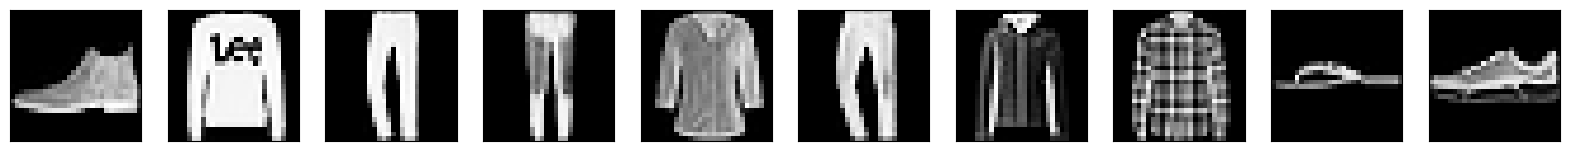

generated


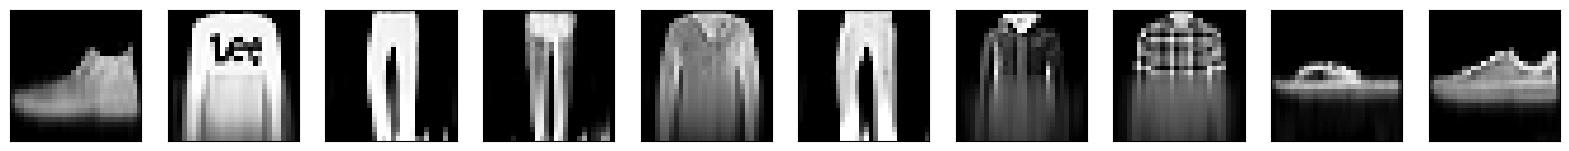

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

epoch: 6, loss_train: 0.0111
original


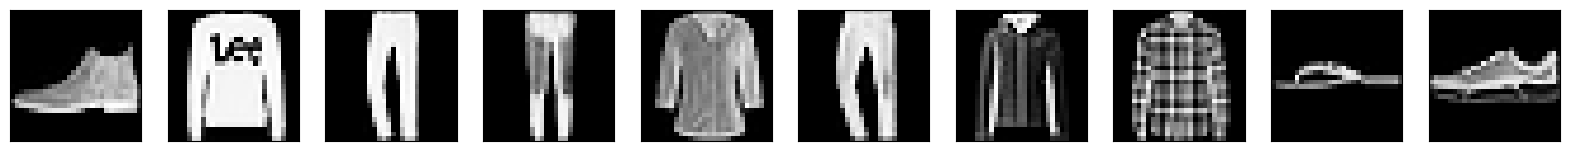

generated


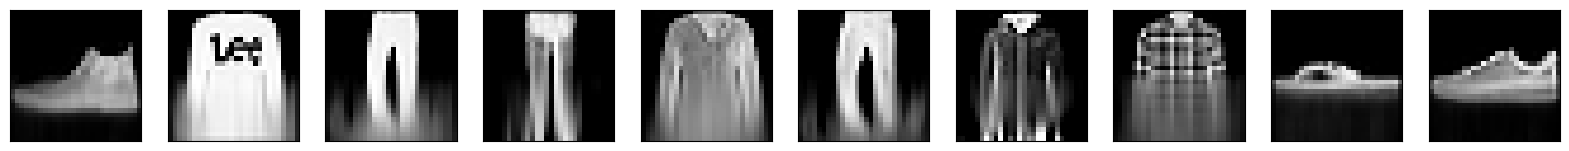

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

epoch: 11, loss_train: 0.0102
original


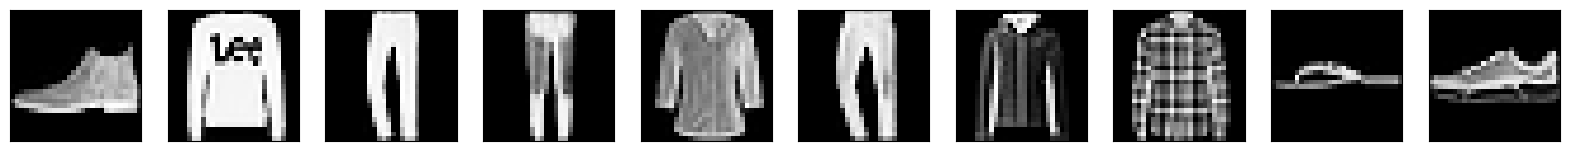

generated


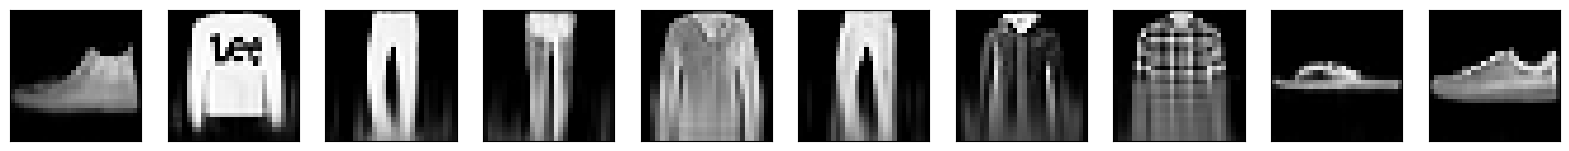

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

epoch: 16, loss_train: 0.0096
original


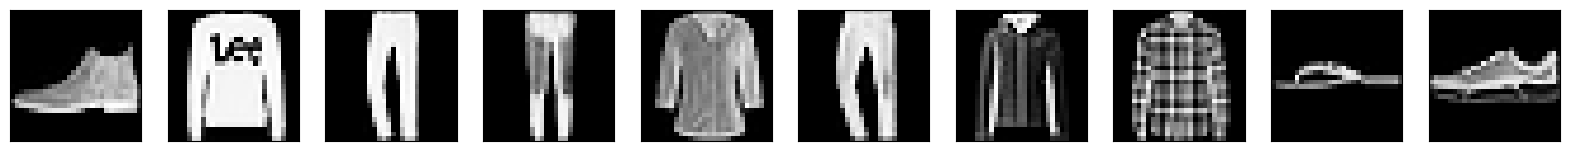

generated


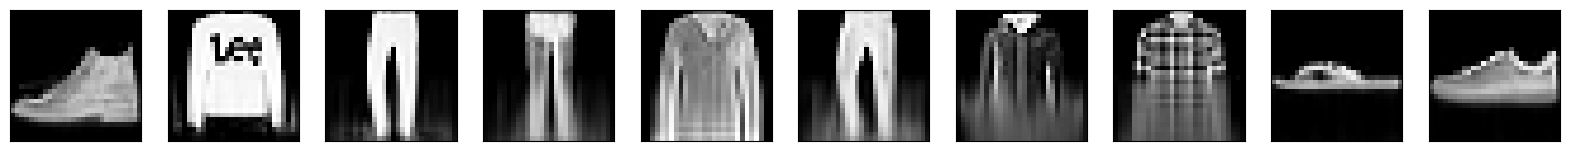

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

epoch: 21, loss_train: 0.0092
original


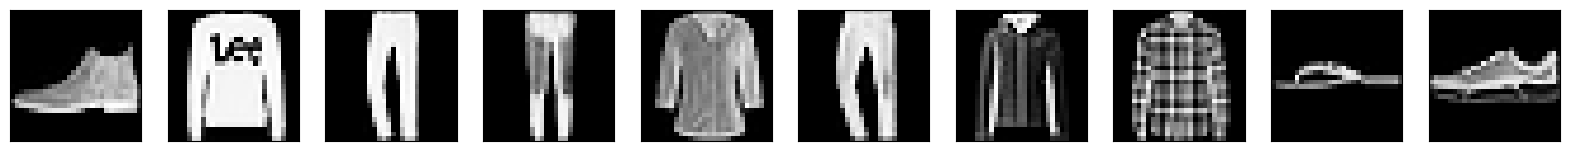

generated


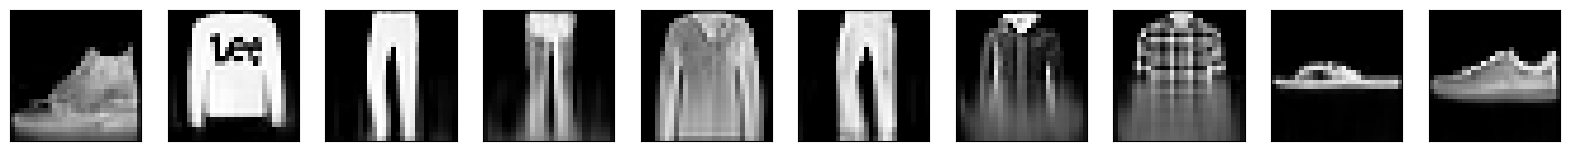

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

epoch: 26, loss_train: 0.0089
original


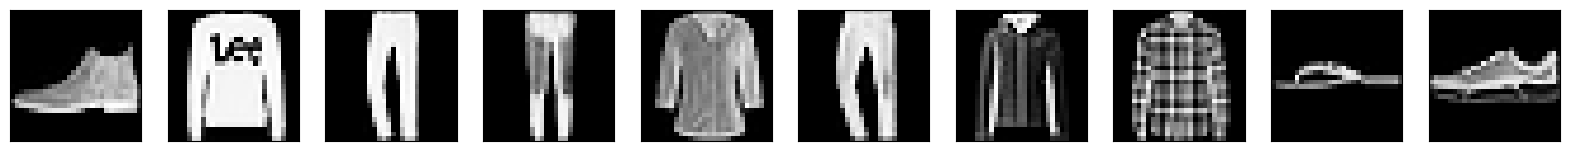

generated


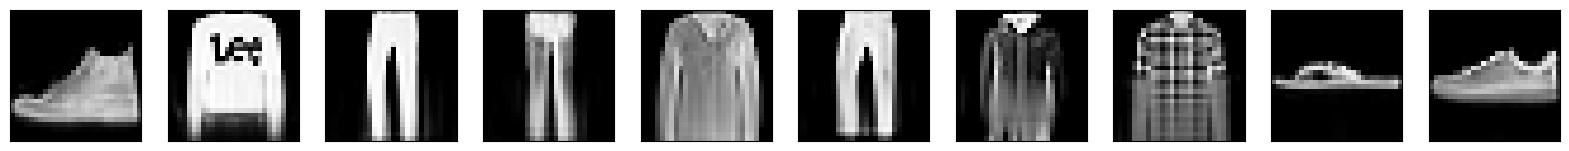

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

  0%|          | 0/6563 [00:00<?, ?it/s]

epoch: 30, loss_train: 0.0087
original


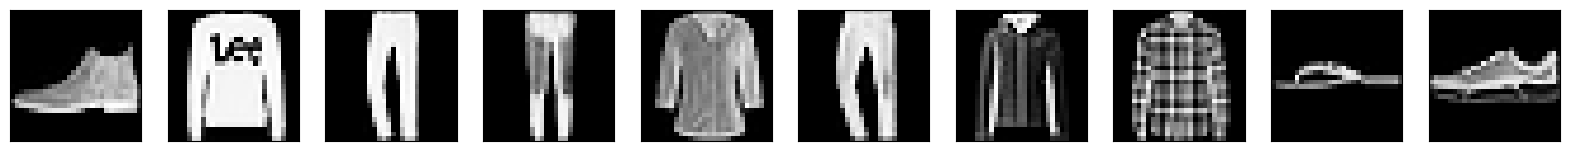

generated


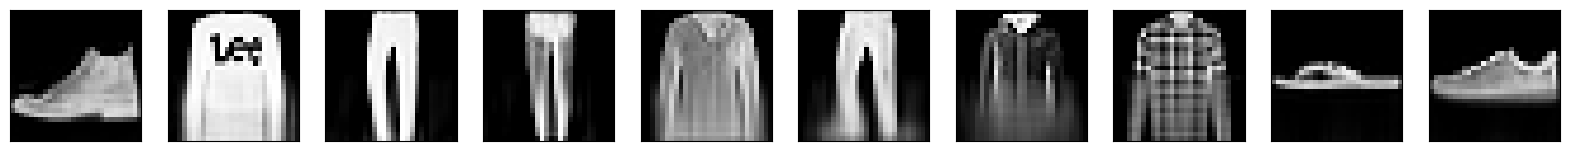

CPU times: user 8min 18s, sys: 1min 44s, total: 10min 2s
Wall time: 10min 4s


In [14]:
%%time
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

record_loss_train = []

n_epochs = 30
verbose = 5


for epoch in tqdm(range(n_epochs)):
    net.train()
    loss_train = 0

    for (x, t) in tqdm(train_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)
        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= len(train_loader)
    record_loss_train.append(loss_train)

    if epoch % verbose == 0 or epoch == n_epochs - 1:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}')
        generate_images()

### 誤差の推移

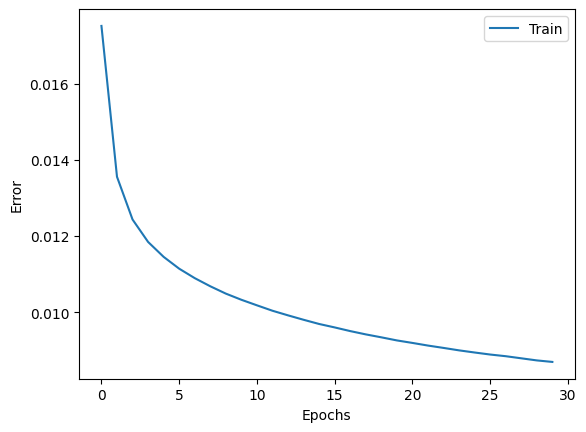

In [15]:
plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()